## 5.0 Embedding Extraction and Visualization

This notebook generates the song embeddings from previous trained models and visualizes the data.

### Table of Contents
[5.1. Setup](#1.)<br>
[5.1.1 Loading libraries](#1.1)<br>
[5.1.2 Setting data directories](#1.2)<br>
[5.1.3 Defining functions](#1.3)<br>
[5.1.4 Reading in trained models and extracting the song embeddings](#1.4)<br>
[5.1.5 Final preprocessing using Keras model applications](#1.5)<br>

[5.2. Extraction of Embeddings](#2.)<br>
[5.2.1 Loading of trained model and generating the embeddings](#2.1)<br>

[5.3. Visualization using T-SNE](#3.)<br>
[5.3.1 Initial Run with default parameters 2D and 3D vidualization](#3.1)<br>
[5.3.2 Testing with different perplexities](#3.2)<br>

[5.4. Checking Songs with Similarity](#4.)<br>
[5.4.1 First comparison](#4.1)<br>
[5.4.2 Second comparison](#4.2)<br>

### 5.1. Setup <a class="anchor" id="1."></a>

#### 5.1.1 Loading libraries <a class="anchor" id="1.1"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import timeit
import datetime

import keras
from keras import applications
from keras.models import load_model, Model

from os.path import isfile

from sklearn.manifold import TSNE

import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.io as pio

import IPython.display as ipd


Using TensorFlow backend.


#### 5.1.2 Setting data directories <a class="anchor" id="1.2"></a>

In [2]:
# Set the model description, directory and the weights file
model_description = 'vgg16_4v2'
model_dir = f'./models/{model_description}'
print("Directory of model: {}".format(model_dir))
weights_file = 'weights.best.h5'
print("Saved model weights file: {}".format(weights_file))

ds_description = '1x10s'
# Set seed num, if no seed number, set as None
ds_seed_num = 'seedNone'

# Set the directory for the spectrograms
data_dir = f'./data/spect_subsample_{ds_description}_np'
print("\nDirectory of spectrograms: {}".format(data_dir))
print("Labels: train_Y_{}_{}_np.npy".format(ds_description, ds_seed_num))

# Set embedding directory
embedding_dir = './data/song_embeddings'
# mp3 audio files directory
audio_dir = f'./data/fma_small'

Directory of model: ./models/vgg16_4v2
Saved model weights file: weights.best.h5

Directory of spectrograms: ./data/spect_subsample_1x10s_np
Labels: train_Y_1x10s_seedNone_np.npy


In [3]:
genre_dict = {0 : 'Hip-Hop',
              1 : 'Pop',
              2 : 'Folk',
              3 : 'Experimental',
              4 : 'Rock',
              5 : 'International',
              6 : 'Electronic',
              7 : 'Instrumental',
              8 : 'Famous'}

#### 5.1.3 Defining functions <a class="anchor" id="1.3"></a>

In [4]:
def load_data(data_dir, ds_description, ds_seed_num, str_X, str_Y):
    '''
    Loads the .npy data files generated previously from the pre-processing ipynb
    Note: .npy files need to be in the format: train_spect_{ds_description}_np.npy
    
    Inputs
    ------
    data_dir: directory of the .npy files
    ds_description: e.g. '5x10s'  5 subsamples of 10s length
    str_X: str name of the 'X' data, either: 'spect' or 'X'
    str_Y: str name of the 'Y' data, either: 'labels' or 'Y'
    
    Returns
    -------
    6 numpy arrays of:
        train_{str_X}, train_{str_Y}, val_{str_X}, val_{str_Y}, test_{str_X}, test_{str_Y}
    '''
    assert (str_X in ['spect','X']), "Assertion Error, str_X must be either 'spect' or 'X'."
    assert (str_Y in ['labels','Y']), "Assertion Error, str_Y must be either 'labels' or 'Y'."
    
    if ds_seed_num != None:
        ds_description_with_seed = f'{ds_description}_{ds_seed_num}'
    else:
        ds_description_with_seed = f'{ds_description}'
    
    print("Loading .npy data files...")
    # Start timer
    start_time = timeit.default_timer()

    train_str_X = np.load(f'{data_dir}/train_{str_X}_{ds_description_with_seed}_np.npy')
    val_str_X = np.load(f'{data_dir}/val_{str_X}_{ds_description_with_seed}_np.npy')
    test_str_X = np.load(f'{data_dir}/test_{str_X}_{ds_description_with_seed}_np.npy')

    if str_Y == 'labels':
        train_str_Y = np.load(f'{data_dir}/train_{str_Y}_{ds_description}_np.npy')
        val_str_Y = np.load(f'{data_dir}/val_{str_Y}_{ds_description}_np.npy')
        test_str_Y = np.load(f'{data_dir}/test_{str_Y}_{ds_description}_np.npy')
    else:
        train_str_Y = np.load(f'{data_dir}/train_{str_Y}_{ds_description_with_seed}_np.npy')
        val_str_Y = np.load(f'{data_dir}/val_{str_Y}_{ds_description_with_seed}_np.npy')
        test_str_Y = np.load(f'{data_dir}/test_{str_Y}_{ds_description_with_seed}_np.npy')        
    
    elapsed = str(datetime.timedelta(seconds = timeit.default_timer() - start_time))
    print("", end='\n')
    print("Total processing time (h:mm:ss): {}".format(elapsed[:-7]))
    print("\nLoaded .npy data files, verifying shape of saved data...")
    print(f"Shape of 'train_{str_X}':", train_str_X.shape)
    print(f"Shape of 'train_{str_Y}':", train_str_Y.shape)

    print(f"Shape of 'val_{str_X}':", val_str_X.shape)
    print(f"Shape of 'val_{str_Y}':", val_str_Y.shape)

    print(f"Shape of 'test_{str_X}':", test_str_X.shape)
    print(f"Shape of 'test_{str_Y}':", test_str_Y.shape)
    
    return train_str_X, train_str_Y, val_str_X, val_str_Y, test_str_X, test_str_Y


def mkdir_p(mypath):
    '''
    Creates a directory. equivalent to using mkdir -p on the command line
    '''
    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: 
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

            
def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    Examples
    --------
    audio_dir = './data/fma_small'
    >>> get_audio_path(audio_dir, 2)
    Returns
    -------    
    '../data/fma_small/000/000002.mp3'
    """
    tid_str = '{:06d}'.format(track_id)
    return f'{audio_dir}/{tid_str[:3]}/{tid_str}.mp3'

In [5]:
def extract_genre_embeddings(full_set_X, model_dir, weights_file='weights.best.h5'):
    '''
    Loads the trained model, and extracts the genre embeddings for the last layer
    
    Inputs
    ------
    full_set_X = single sample of complete data set (spectrogram input), train, val and test included.
    model_dir = str of directory where trained model weights .h5 file is stored
    weights_file = str of weights .h5 filename
    
    Returns
    -------
    embedding_output from the model
    '''
    
    # Load the model
    print(f"Loading model: {model_dir}/{weights_file}")
    model = load_model(f'{model_dir}/{weights_file}')
    
    # Getting the 2nd last layer output before the softmax layer
    embedding_output_model = Model(inputs=model.input, outputs=model.get_layer(index=-2).output)
    
    # Generate the embeddings for the full set of inputs
    embedding_output = embedding_output_model.predict(full_set_X)
    
    print(f"Shape of full set of Embeddings Output: {embedding_output.shape}")
    
    return embedding_output
   

#### 5.1.4 Reading in train, validation, and test data sets <a class="anchor" id="1.4"></a>

In [54]:
famous_X = np.load(f'{data_dir}/famous_spect_{ds_description}_np.npy')

In [6]:
# Reading in the tracks.csv file
tracks_df = pd.read_csv("./tracks.csv", sep=',', index_col=0, header=[0,1])

train_set_df = tracks_df[tracks_df[('set','split')]=='training']
val_set_df = tracks_df[tracks_df[('set','split')]=='validation']
test_set_df = tracks_df[tracks_df[('set','split')]=='test']

# Generating the concatenated (train, val, test) set of track ids and properties 
full_set_df = pd.concat([train_set_df, val_set_df, test_set_df])
full_set_df.head()

set artist                                             \
             split     id                             name favorites   
track_id                                                               
2         training      1                             AWOL         9   
5         training      1                             AWOL         9   
10        training      6                        Kurt Vile        74   
140       training     54  Alec K. Redfearn & the Eyesores        11   
141       training     54  Alec K. Redfearn & the Eyesores        11   

                       track                                                  \
                       title         date_created genre_top genres favorites   
track_id                                                                       
2                       Food  2008-11-26 01:48:12   Hip-Hop   [21]         2   
5                 This World  2008-11-26 01:48:20   Hip-Hop   [21]         6   
10                   Freeway  2008-11-25 17:49:06       Pop   [10]       178   
140       Queen Of The Wires  2008-11-26 01:44:07      Folk   [17]         5   
141                     Ohio  2008-11-26 01:44:10      Folk   [17]         1   

                           
         interest listens  
track_id                   
2            4656    1293  
5            1933    1151  
10          54881   50135  
140          1593    1299  
141           839     725

#### 5.1.5 Final preprocessing using Keras model applications <a class="anchor" id="1.5"></a>

In [56]:
from keras.applications.vgg16 import preprocess_input

famous_X = preprocess_input(famous_X)

### 5.2. Extraction of Embeddings <a class="anchor" id="2."></a>

#### 5.2.1 Loading of trained model and generating the embeddings<a class="anchor" id="2.1"></a>

In [57]:
song_embeddings = np.load(f'{embedding_dir}/song_embedding_v02.npy')
song_embeddings.shape

(7994, 32)

In [58]:
famous = np.zeros((18, 431, 128, 3))

famous[:,:,:,0] = famous_X
famous[:,:,:,1] = famous_X
famous[:,:,:,2] = famous_X

famous_embeddings = extract_genre_embeddings(famous, model_dir, weights_file='weights.best.h5')

Loading model: ./models/vgg16_4v2/weights.best.h5
Shape of full set of Embeddings Output: (18, 32)


In [59]:
full_embeddings = np.append(song_embeddings, famous_embeddings, axis=0)
full_embeddings.shape

(8012, 32)

### 5.3 Visualization Using T-SNE <a class="anchor" id="3."></a>

#### 5.3.1 Initial Run with default parameters 2D and 3D vidualization <a class="anchor" id="3.1"></a>

In [60]:
tsne = TSNE(n_components=3, perplexity=50.0, early_exaggeration=12.0, 
            learning_rate=200.0, n_iter=1000, n_iter_without_progress=300, 
            min_grad_norm=1e-07, metric='euclidean', init='random', 
            verbose=1, random_state=None, method='barnes_hut', angle=0.5)
tsne_results = tsne.fit_transform(full_embeddings)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 8012 samples in 0.011s...
[t-SNE] Computed neighbors for 8012 samples in 1.256s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8012
[t-SNE] Computed conditional probabilities for sample 2000 / 8012
[t-SNE] Computed conditional probabilities for sample 3000 / 8012
[t-SNE] Computed conditional probabilities for sample 4000 / 8012
[t-SNE] Computed conditional probabilities for sample 5000 / 8012
[t-SNE] Computed conditional probabilities for sample 6000 / 8012
[t-SNE] Computed conditional probabilities for sample 7000 / 8012
[t-SNE] Computed conditional probabilities for sample 8000 / 8012
[t-SNE] Computed conditional probabilities for sample 8012 / 8012
[t-SNE] Mean sigma: 1.101533
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.303543
[t-SNE] KL divergence after 1000 iterations: 1.119974


In [61]:
# Saving T-SNE results
np.save(f'{embedding_dir}/tsne_results_with_famous_p50',tsne_results)

In [7]:
famous_df = pd.read_csv("./data/famous_labels.csv", header = [0,1], encoding='latin-1')
famous_df

track          
                                                title genre_top
0                              FAKE LOVE' Official MV    famous
1             Andrea Bocelli - Ali di libertà (audio)    famous
2                   Auli'i Cravalho - How Far I'll Go    famous
3   Bebe Rexha - Meant to Be (feat. Florida Georgi...    famous
4                                   Deep as the Night    famous
5         Dua Lipa - New Rules (Official Music Video)    famous
6                                          God's Plan    famous
7                  Holiday Boulevard of Broken Dreams    famous
8                           Imagine Dragons - Thunder    famous
9   Justin Bieber - Despacito [Music Video] ft. Lu...    famous
10                                            MVLemon    famous
11          Nicky Jam x J. Balvin - X (EQUIS)- Lyrics    famous
12  Reckless Love (Official Lyric Video) - Cory As...    famous
13                                         Redemption    famous
14  Sting + Shaggy - 44876 (Audio) ft. Morgan Heri...    famous
15  The Greatest Showman The Greatest Show Lyric V...    famous
16  Tony Bennett +  Diana Krall - Love Is Here To ...    famous
17  Zedd  Maren Morris  Grey - The Middle (Officia...    famous

In [8]:
full_set_df = full_set_df.append(famous_df)

In [14]:
full_flat = pd.read_csv("./neural_notes_web_app/data/full_set_df_collapse_header.csv")
famous_flat = pd.read_csv("./data/famous_labels_flat.csv", header = [0], encoding='latin-1')

full_flat = full_flat.append(famous_flat)
full_flat

Unnamed: 0  artist_favorites  artist_id  \
0            0.0               9.0        1.0   
1            1.0               9.0        1.0   
2            2.0              74.0        6.0   
3            3.0              11.0       54.0   
4            4.0              11.0       54.0   
5            5.0               7.0      127.0   
6            6.0               7.0      127.0   
7            7.0               7.0      127.0   
8            8.0               7.0      127.0   
9            9.0               7.0      127.0   
10          10.0               7.0      127.0   
11          11.0               7.0      127.0   
12          12.0               7.0      127.0   
13          13.0               7.0      127.0   
14          14.0               7.0      127.0   
15          15.0               7.0      127.0   
16          16.0              11.0       66.0   
17          17.0              27.0       80.0   
18          18.0               3.0       81.0   
19          19.0              20.0       84.0   
20          20.0              14.0       91.0   
21          21.0               9.0      101.0   
22          22.0               9.0      101.0   
23          23.0               9.0      101.0   
24          24.0              11.0      106.0   
25          25.0               0.0      126.0   
26          26.0               7.0      127.0   
27          27.0               7.0      127.0   
28          28.0               7.0      127.0   
29          29.0              15.0      135.0   
...          ...               ...        ...   
7982      7982.0               0.0    23687.0   
7983      7983.0               0.0    23748.0   
7984      7984.0               0.0    23748.0   
7985      7985.0               0.0    23748.0   
7986      7986.0              18.0    16031.0   
7987      7987.0              18.0    16031.0   
7988      7988.0              17.0    23208.0   
7989      7989.0              17.0    23208.0   
7990      7990.0              17.0    23208.0   
7991      7991.0              17.0    23208.0   
7992      7992.0              17.0    23208.0   
7993      7993.0              17.0    23208.0   
0            NaN               NaN        NaN   
1            NaN               NaN        NaN   
2            NaN               NaN        NaN   
3            NaN               NaN        NaN   
4            NaN               NaN        NaN   
5            NaN               NaN        NaN   
6            NaN               NaN        NaN   
7            NaN               NaN        NaN   
8            NaN               NaN        NaN   
9            NaN               NaN        NaN   
10           NaN               NaN        NaN   
11           NaN               NaN        NaN   
12           NaN               NaN        NaN   
13           NaN               NaN        NaN   
14           NaN               NaN        NaN   
15           NaN               NaN        NaN   
16           NaN               NaN        NaN   
17           NaN               NaN        NaN   

                          artist_name set_split           track_date  \
0                                AWOL  training  2008-11-26 01:48:12   
1                                AWOL  training  2008-11-26 01:48:20   
2                           Kurt Vile  training  2008-11-25 17:49:06   
3     Alec K. Redfearn & the Eyesores  training  2008-11-26 01:44:07   
4     Alec K. Redfearn & the Eyesores  training  2008-11-26 01:44:10   
5                            Ed Askew  training  2008-11-26 01:46:54   
6                            Ed Askew  training  2008-11-26 01:47:02   
7                            Ed Askew  training  2008-11-26 01:47:05   
8                            Ed Askew  training  2008-11-26 01:47:15   
9                            Ed Askew  training  2008-11-26 01:47:25   
10                           Ed Askew  training  2008-11-26 01:47:34   
11                           Ed Askew  training  2008-11-26 01:47:37   
12                           Ed

In [15]:
full_flat.to_csv( path_or_buf = "./neural_notes_web_app/data/full_set_with_famous_df_collapse_header.csv")

In [9]:
full_set_df['tsne-3d-one'] = tsne_results[:,0]
full_set_df['tsne-3d-two'] = tsne_results[:,1]
full_set_df['tsne-3d-three'] = tsne_results[:,2]

NameError: name 'tsne_results' is not defined

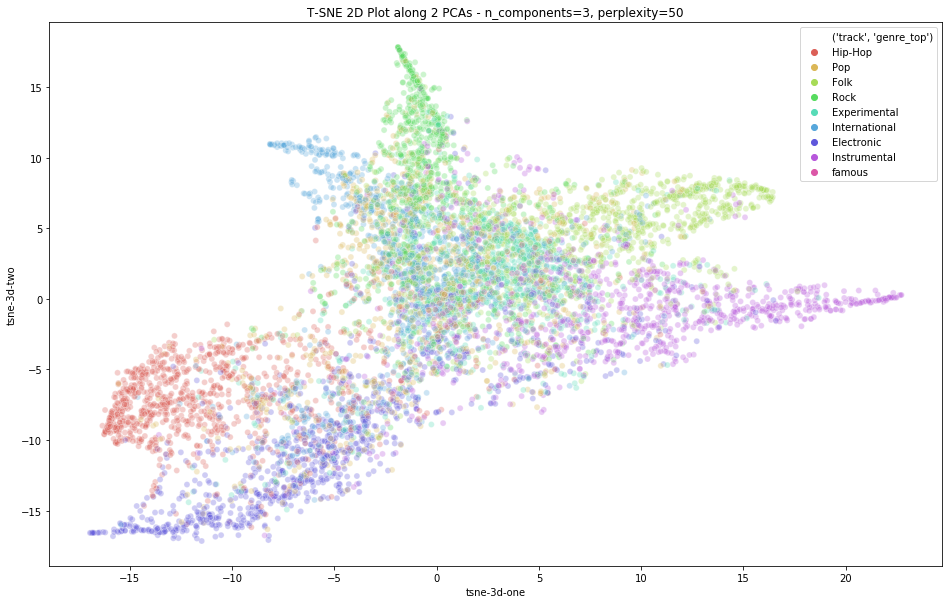

In [85]:
# 2D plot

plt.figure(figsize=(16,10))
ax = sns.scatterplot(x="tsne-3d-one", y="tsne-3d-two",
                     hue=('track','genre_top'),
                     palette=sns.color_palette("hls", 9),
                     data=full_set_df,
                     legend="full",
                     alpha=0.3)

ax.set_title('T-SNE 2D Plot along 2 PCAs - n_components=3, perplexity=50')
plt.show()

In [74]:
# 3D plot

plotly.tools.set_credentials_file(username='kuangweihuang', api_key='NRo8jGkN7UDyKU4c1hwR')

trace_set = []

genre_colors = ['hsl('+str(h)+',70%'+',50%)' for h in np.linspace(0, 255, len(genre_dict))]

for i in range(len(genre_dict)):
    
    trace_set.append(go.Scatter3d(x=full_set_df[full_set_df[('track','genre_top')]==genre_dict[i]]["tsne-3d-one"], 
                                  y=full_set_df[full_set_df[('track','genre_top')]==genre_dict[i]]["tsne-3d-two"],
                                  z=full_set_df[full_set_df[('track','genre_top')]==genre_dict[i]]["tsne-3d-three"],
                                  mode='markers', name=genre_dict[i],
                                  hovertemplate = "<i>Title</i>: %{text}"
                                                  "<br><i>PCA-One</i>: %{x}"
                                                  "<br><i>PCA-Two</i>: %{y}"
                                                  "<br><i>PCA-Three</i>: %{z}",
                                  marker=dict(size=3, 
                                              line=dict(width=0.1),
                                              color=genre_colors[i],
                                              opacity=.7),
                                  text = full_set_df[full_set_df[('track','genre_top')]==genre_dict[i]][('track','title')]
                                 )
                    )

layout = go.Layout(margin=dict(l=0, r=0, b=0, t=50),
                   title= 'T-SNE 3D Plot along 3 PCAs - n_components=3, perplexity=50',
                   hovermode= 'closest',
                   width=900, height=700,
                   scene = dict(xaxis = dict(title='TSNE-PCA-One'),
                               yaxis = dict(title='TSNE-PCA-Two'),
                               zaxis = dict(title='TSNE-PCA-Three'),
                               ),
                  )

fig = go.Figure(data=trace_set, layout=layout)
py.iplot(fig, filename='T-SNE 3D Plot along 3 PCAs - n_components=3, perplexity=50')

#### 5.3.2 Testing with different perplexities <a class="anchor" id="3.2"></a>

In [52]:
def gen_tsne_results(song_embeddings, embedding_dir, n_components=3, perplexity_list=[5,10,20,30,40,50,75],
                     save=True, save_file='tsne_results_temp'):
    '''
    Generates a set of T-SNE results for a list of perplexities
    
    Inputs
    ------
    song_embeddings:
    embedding_dir: 
    n_components: default 3
    perplexity_list
    save: flag for saving
    save_file: filename for the set of results to be saved
    Returns
    -------
    A set of T-SNE results.  Also saves the results to the drive
    '''
    # Define an empty list
    tsne_results_set = []
    
    for i, p in zip(range(len(perplexity_list)), perplexity_list):
        # Instantiate a tsne
        tsne = TSNE(n_components=3, perplexity=p, early_exaggeration=12.0, 
                    learning_rate=200.0, n_iter=5000, n_iter_without_progress=300, 
                    min_grad_norm=1e-07, metric='euclidean', init='random', 
                    verbose=1, random_state=None, method='barnes_hut', angle=0.5)
        
        tsne_results_set.append(tsne.fit_transform(song_embeddings))
    
        if save==True:
            np.save(f'{embedding_dir}/{save_file}_p{p}',tsne_results_set[i])
    
    return tsne_results_set


def load_tsne_results(full_set_df, embedding_dir, results_file):
    '''
    Generates a 3D plotly scatter plot for the tsne results in the dtatframe: full_set_df
    
    Inputs
    ------
    full_set_df: pandas DF with column names:
        - ('track','genre_top')
        - ('track','title')
    genre_dict: dictionary of genres in the format, e.g.: {0: 'Hip-hop', 1: 'Pop', ...}    
    embedding_dir: directory containing the embeddings and results file
    results_file: the tsne results filename
    
    Returns
    -------
    full_set_df with additional columns:
        - 'tsen-3d-one'
        - 'tsen-3d-two'
        - 'tsen-3d-three'
    '''
    
    # Load results
    tsne_results = np.load(f'{embedding_dir}/{results_file}.npy')
    
    # Set the dataframes to include the tsne_results
    full_set_df['tsne-3d-one'] = tsne_results[:,0]
    full_set_df['tsne-3d-two'] = tsne_results[:,1]
    full_set_df['tsne-3d-three'] = tsne_results[:,2]
    
    return full_set_df


def gen_tsne_3Dplot(full_set_df, genre_dict, embedding_dir, results_file, 
                    username='kuangweihuang', api_key='NRo8jGkN7UDyKU4c1hwR'):
    '''
    Generates a 3D plotly scatter plot for the tsne results in the dtatframe: full_set_df
    
    Inputs
    ------
    full_set_df: pandas DF with column names:
        - ('track','genre_top')
        - ('track','title')
        - 'tsen-3d-one'
        - 'tsen-3d-two'
        - 'tsen-3d-three'
    genre_dict: dictionary of genres in the format, e.g.: {0: 'Hip-hop', 1: 'Pop', ...}    
    embedding_dir: directory containing the embeddings and results file
    results_file: the tsne results filename
    
    Returns
    -------
    Generates a 3D scatter plot.
    '''
        
    plotly.tools.set_credentials_file(username=username, api_key=api_key)

    trace_set = []

    genre_colors = ['hsl('+str(h)+',70%'+',50%)' for h in np.linspace(0, 255, len(genre_dict))]

    for i in range(len(genre_dict)):

        trace_set.append(go.Scatter3d(x=full_set_df[full_set_df[('track','genre_top')]==genre_dict[i]]["tsne-3d-one"], 
                                      y=full_set_df[full_set_df[('track','genre_top')]==genre_dict[i]]["tsne-3d-two"],
                                      z=full_set_df[full_set_df[('track','genre_top')]==genre_dict[i]]["tsne-3d-three"],
                                      mode='markers', name=genre_dict[i],
                                      hovertemplate = "<i>Title</i>: %{text}"
                                                      "<br><i>PCA-One</i>: %{x}"
                                                      "<br><i>PCA-Two</i>: %{y}"
                                                      "<br><i>PCA-Three</i>: %{z}",
                                      marker=dict(size=3, 
                                                  line=dict(width=0.1),
                                                  color=genre_colors[i],
                                                  opacity=1),
                                      text = full_set_df[full_set_df[('track','genre_top')]==genre_dict[i]][('track','title')]
                                     )
                        )

    layout = go.Layout(margin=dict(l=0, r=0, b=0, t=50),
                       title= f'T-SNE 3D Plot along 3 PCAs - n_components=3, results={results_file}',
                       hovermode= 'closest',
                       width=900, height=700,
                       scene = dict(xaxis = dict(title='TSNE-PCA-One'),
                                   yaxis = dict(title='TSNE-PCA-Two'),
                                   zaxis = dict(title='TSNE-PCA-Three'),
                                   ),
                      )

    fig = go.Figure(data=trace_set, layout=layout)
    
    return py.iplot(fig, filename=f'T-SNE 3D Plot along 3 PCAs - n_components=3, results={results_file}')

In [76]:
# Note: This step takes a long time to complete
tsne_results_set = gen_tsne_results(song_embeddings, embedding_dir, n_components=3, 
                                    perplexity_list=[5,10,20,30,40,50,75], 
                                    save=True, save_file='tsne_results_set1')

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 7994 samples in 0.014s...
[t-SNE] Computed neighbors for 7994 samples in 0.682s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7994
[t-SNE] Computed conditional probabilities for sample 2000 / 7994
[t-SNE] Computed conditional probabilities for sample 3000 / 7994
[t-SNE] Computed conditional probabilities for sample 4000 / 7994
[t-SNE] Computed conditional probabilities for sample 5000 / 7994
[t-SNE] Computed conditional probabilities for sample 6000 / 7994
[t-SNE] Computed conditional probabilities for sample 7000 / 7994
[t-SNE] Computed conditional probabilities for sample 7994 / 7994
[t-SNE] Mean sigma: 0.580806
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.158783
[t-SNE] Error after 5000 iterations: 1.207825
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 7994 samples in 0.013s...
[t-SNE] Computed neighbors for 7994 samples in 0.770s...
[t-SNE] Computed conditional probabil

In [53]:
# Load results and plot 3D scatter
full_set_df = load_tsne_results(full_set_df, embedding_dir, results_file='tsne_results_set1_p5')
gen_tsne_3Dplot(full_set_df, genre_dict, embedding_dir, results_file='tsne_results_set1_p5')

In [54]:
# Load results and plot 3D scatter
full_set_df = load_tsne_results(full_set_df, embedding_dir, results_file='tsne_results_set1_p10')
gen_tsne_3Dplot(full_set_df, genre_dict, embedding_dir, results_file='tsne_results_set1_p10')

In [55]:
# Load results and plot 3D scatter
full_set_df = load_tsne_results(full_set_df, embedding_dir, results_file='tsne_results_set1_p20')
gen_tsne_3Dplot(full_set_df, genre_dict, embedding_dir, results_file='tsne_results_set1_p20')

In [56]:
# Load results and plot 3D scatter
full_set_df = load_tsne_results(full_set_df, embedding_dir, results_file='tsne_results_set1_p30')
gen_tsne_3Dplot(full_set_df, genre_dict, embedding_dir, results_file='tsne_results_set1_p30')

In [57]:
# Load results and plot 3D scatter
full_set_df = load_tsne_results(full_set_df, embedding_dir, results_file='tsne_results_set1_p40')
gen_tsne_3Dplot(full_set_df, genre_dict, embedding_dir, results_file='tsne_results_set1_p40')

In [58]:
# Load results and plot 3D scatter
full_set_df = load_tsne_results(full_set_df, embedding_dir, results_file='tsne_results_set1_p50')
gen_tsne_3Dplot(full_set_df, genre_dict, embedding_dir, results_file='tsne_results_set1_p50')

In [59]:
# Load results and plot 3D scatter
full_set_df = load_tsne_results(full_set_df, embedding_dir, results_file='tsne_results_set1_p75')
gen_tsne_3Dplot(full_set_df, genre_dict, embedding_dir, results_file='tsne_results_set1_p75')

### 5.4 Checking Songs with Similarity <a class="anchor" id="4."></a>

#### 5.4.1 First comparision <a class="anchor" id="3.2"></a>

In [60]:
# Using t-sne results with a perplexity of 50, 
full_set_df = load_tsne_results(full_set_df, embedding_dir, results_file='tsne_results_set1_p50')

# Facebook, Haribos and Roaches
comparison_1 = pd.concat([full_set_df[full_set_df[('track','title')].str.contains('Facebook')],
                          full_set_df[full_set_df[('track','title')].str.contains('Haribos')],
                          full_set_df[full_set_df[('track','title')].str.contains('Roaches')]
                         ], axis=0)
               
comparison_1

set artist                               \
             split     id               name favorites   
track_id                                                 
133798    training  11346       David Rovics         4   
98621     training  17784  KINGS OF THE CITY        11   
134610    training  21888       Donnie Ozone         3   

                              track                                            \
                              title         date_created genre_top     genres   
track_id                                                                        
133798                     Facebook  2016-03-06 15:05:45      Folk  [17, 103]   
98621                       Haribos  2014-02-05 17:53:40   Hip-Hop  [21, 539]   
134610    Roaches (Featuring Pot-C)  2016-03-24 23:57:13   Hip-Hop       [21]   

                                    tsne-3d-one tsne-3d-two tsne-3d-three  
         favorites interest listens                                        
track_id                                                                   
133798           0      803     678    6.038671   -6.818027      8.508407  
98621            2     2018    1679    6.024767   -6.899234      8.469405  
134610           4     4636    3957    5.997888   -6.968693      8.463788

In [61]:
gen_tsne_3Dplot(comparison_1, genre_dict, embedding_dir, results_file='comparison_1')

In [35]:
i=0
print("Genre: {}, Track Title: {}".format(
comparison_1.iloc[i][('track','genre_top')], comparison_1.iloc[i][('track','title')]))
ipd.Audio(get_audio_path(audio_dir, comparison_1.index[i]))

Genre: Folk, Track Title: Facebook


In [36]:
i=1
print("Genre: {}, Track Title: {}".format(
comparison_1.iloc[i][('track','genre_top')], comparison_1.iloc[i][('track','title')]))
ipd.Audio(get_audio_path(audio_dir, comparison_1.index[i]))

Genre: Hip-Hop, Track Title: Haribos


In [37]:
i=2
print("Genre: {}, Track Title: {}".format(
comparison_1.iloc[i][('track','genre_top')], comparison_1.iloc[i][('track','title')]))
ipd.Audio(get_audio_path(audio_dir, comparison_1.index[i]))

Genre: Hip-Hop, Track Title: Roaches (Featuring Pot-C)


#### 5.4.2 Second comparision <a class="anchor" id="3.2"></a>

In [65]:
# Using t-sne results with a perplexity of 50, 
full_set_df = load_tsne_results(full_set_df, embedding_dir, results_file='tsne_results_set1_p50')

# The Tumen Horsemen, Echo of Suggestion and Tide Rising
comparison_2 = pd.concat([full_set_df[full_set_df[('track','title')].str.contains('The Tumen Horsemen')],
                          full_set_df[full_set_df[('track','title')].str.contains('Echo of Suggestion')],
                          full_set_df[full_set_df[('track','title')].str.contains('Tide Rising')]
                         ], axis=0)
               
comparison_2

set artist                                      track  \
             split     id         name favorites               title   
track_id                                                               
71172     training  11213       Frenic        11  The Tumen Horsemen   
87361     training   4202  Nisi Period         2  Echo of Suggestion   
127287    training  21078       Myndra         0         Tide Rising   

                                                                               \
                 date_created genre_top             genres favorites interest   
track_id                                                                        
71172     2012-10-16 15:15:18   Hip-Hop              [811]        13     8028   
87361     2013-07-20 15:25:47      Rock  [58, 89, 98, 113]         5     4093   
127287    2015-11-04 10:06:10       Pop               [10]         2     1461   

                 tsne-3d-one tsne-3d-two tsne-3d-three  
         listens                                        
track_id                                                
71172       6184    2.076381   -2.223397      2.659557  
87361       2950    1.981893   -2.263721      2.537510  
127287       930    1.990432   -2.330684      2.452335

In [66]:
gen_tsne_3Dplot(comparison_2, genre_dict, embedding_dir, results_file='comparison_2')

In [68]:
i=0
print("Genre: {}, Track Title: {}".format(
comparison_2.iloc[i][('track','genre_top')], comparison_2.iloc[i][('track','title')]))
ipd.Audio(get_audio_path(audio_dir, comparison_2.index[i]))

Genre: Hip-Hop, Track Title: The Tumen Horsemen


In [69]:
i=1
print("Genre: {}, Track Title: {}".format(
comparison_2.iloc[i][('track','genre_top')], comparison_2.iloc[i][('track','title')]))
ipd.Audio(get_audio_path(audio_dir, comparison_2.index[i]))

Genre: Rock, Track Title: Echo of Suggestion


In [70]:
i=2
print("Genre: {}, Track Title: {}".format(
comparison_2.iloc[i][('track','genre_top')], comparison_2.iloc[i][('track','title')]))
ipd.Audio(get_audio_path(audio_dir, comparison_2.index[i]))

Genre: Pop, Track Title: Tide Rising
